In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
import gi
gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm

In [3]:
import sys
from clmm import modeling as m

In [4]:
from astropy.cosmology import FlatLambdaCDM
astropy_cosmology_object = FlatLambdaCDM(H0=70, Om0=0.27, Ob0=0.045)
cosmo_ccl = m.cclify_astropy_cosmo(astropy_cosmology_object)

In [5]:
mass_Delta            = 200    # Mass defintion: mean matter density
cluster_mass          = 1.0e15 # Msun / h
cluster_concentration = 4.0
z_max                 = 3.0
z_cluster             = 1.0
z_source              = 2.0
alpha                 = 0.19 # log slope for the einasto profile

In [6]:
#########################
# Initializing NumCosmo #
#########################
Ncm.cfg_init ()

##################
# Set Cosmology ##
##################
cosmo = Nc.HICosmo.new_from_name (Nc.HICosmo, "NcHICosmoDEXcdm")
cosmo.omega_x2omega_k ()

cosmo.props.w       = -1.0
cosmo.props.H0 = cosmo_ccl['H0']

cosmo.param_set_by_name ("H0",     cosmo_ccl['H0'])
cosmo.param_set_by_name ("Omegab", cosmo_ccl['Omega_b'])
cosmo.param_set_by_name ("Omegac", cosmo_ccl['Omega_c'])
cosmo.param_set_by_name ("w",      -1.0)
cosmo.param_set_by_name ("Omegak",  0.0)
cosmo.param_set_by_name ("Tgamma0", 0.0)


In [7]:
##########################
# Config Cluster/Source ##
##########################

# Correction factor for the critical mass density 
# NumCosmo uses the gravitational constant value, G, from CODATA 2018. 
# cluster_toolkit defines a macro for rho_c, which provides a different value in comparison to NumCosmo.
# This correction factor is applied to the cluster mass value.
cor_factor = 2.77533742639e+11 * m._patch_zevolution_cluster_toolkit_rho_m (1.0, 0.0) / Ncm.C.crit_mass_density_h2_solar_mass_Mpc3 ()
reltol = 1.0e-9
lnXi   = math.log (1.0e-4)
lnXf   = math.log (1.0e+4)
improve_prec = True

# NumCosmo Density profile
nc_nfw = Nc.HaloDensityProfileNFW.new (Nc.HaloDensityProfileMassDef.MEAN, mass_Delta)
nc_nfw.props.MDelta = cluster_mass / cor_factor / cosmo.h ()
nc_nfw.props.cDelta = cluster_concentration

nc_ein = Nc.HaloDensityProfileEinasto.new (Nc.HaloDensityProfileMassDef.MEAN, mass_Delta)
nc_ein.props.MDelta = cluster_mass / cor_factor / cosmo.h ()
nc_ein.props.cDelta = cluster_concentration
nc_ein.props.alpha = alpha

if improve_prec:
    nc_ein.set_reltol (reltol) 
    nc_ein.set_lnXi (lnXi)
    nc_ein.set_lnXf (lnXf)

dist = Nc.Distance.new (z_max)
smd  = Nc.WLSurfaceMassDensity.new (dist)

smd.prepare (cosmo)


In [15]:
r     = np.logspace(-2,2,100) # Mpc/h
nc_Sigma_ein  = smd.sigma_array (nc_ein, cosmo, r, 1./cosmo.h(), cor_factor/cosmo.h()/1.e12, z_cluster)
nc_Sigma_nfw  = smd.sigma_array (nc_nfw, cosmo, r, 1./cosmo.h(), cor_factor/cosmo.h()/1.e12, z_cluster)

In [16]:
clmm_Sigma_nfw = m.predict_surface_density(r, cluster_mass, cluster_concentration, z_cluster, cosmo=cosmo_ccl, 
                                  delta_mdef=mass_Delta, 
                                  halo_profile_model='nfw')
clmm_Sigma_ein = m.predict_surface_density(r, cluster_mass, cluster_concentration, z_cluster, cosmo=cosmo_ccl, 
                                  delta_mdef=mass_Delta, 
                                  halo_profile_model='einasto', alpha=alpha)


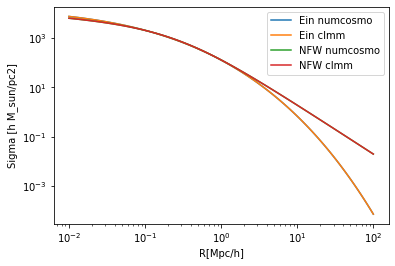

In [17]:
plt.loglog(r, nc_Sigma_ein, label='Ein numcosmo')
plt.loglog(r, clmm_Sigma_ein, label='Ein clmm')
plt.loglog(r, nc_Sigma_nfw, label='NFW numcosmo')
plt.loglog(r, clmm_Sigma_nfw, label='NFW clmm')
plt.xlabel('R[Mpc/h]')
plt.ylabel('Sigma [h M_sun/pc2]')

plt.legend()

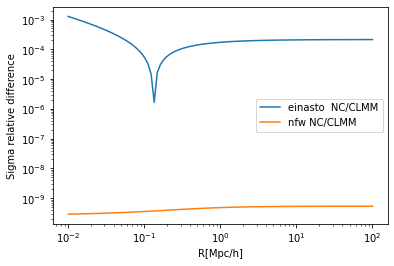

In [18]:
plt.loglog(r, np.abs(nc_Sigma_ein/clmm_Sigma_ein-1.), label='einasto  NC/CLMM')
plt.loglog(r, np.abs(nc_Sigma_nfw/clmm_Sigma_nfw-1.), label='nfw NC/CLMM')
plt.xlabel('R[Mpc/h]')
plt.ylabel('Sigma relative difference')
plt.legend()

In [19]:
nc_DeltaSigma_ein  = smd.sigma_excess_array (nc_ein, cosmo, r, 1./cosmo.h(), cor_factor/cosmo.h()/1.e12, z_cluster)
nc_DeltaSigma_nfw  = smd.sigma_excess_array (nc_nfw, cosmo, r, 1./cosmo.h(), cor_factor/cosmo.h()/1.e12, z_cluster)

clmm_DeltaSigma_ein = m.predict_excess_surface_density(r, cluster_mass, cluster_concentration, z_cluster, cosmo=cosmo_ccl, 
                                   delta_mdef=mass_Delta, 
                                   halo_profile_model='einasto', alpha=alpha)

clmm_DeltaSigma_nfw = m.predict_excess_surface_density(r, cluster_mass, cluster_concentration, z_cluster, cosmo=cosmo_ccl, 
                                   delta_mdef=mass_Delta, 
                                   halo_profile_model='nfw')



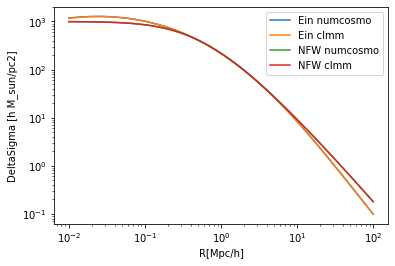

In [20]:
plt.loglog(r, nc_DeltaSigma_ein, label='Ein numcosmo')
plt.loglog(r, clmm_DeltaSigma_ein, label='Ein clmm')
plt.loglog(r, nc_DeltaSigma_nfw, label='NFW numcosmo')
plt.loglog(r, clmm_DeltaSigma_nfw, label='NFW clmm')
plt.ylabel('DeltaSigma [h M_sun/pc2]')
plt.xlabel('R[Mpc/h]')
plt.legend()

Text(0, 0.5, 'DeltaSigma relative difference')

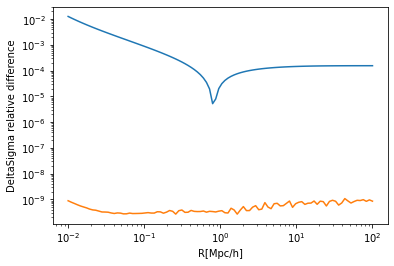

In [21]:
plt.loglog(r, np.abs(nc_DeltaSigma_ein/clmm_DeltaSigma_ein-1.))
plt.plot(r, np.abs(nc_DeltaSigma_nfw/clmm_DeltaSigma_nfw-1.))
plt.xlabel('R[Mpc/h]')
plt.ylabel('DeltaSigma relative difference')